# Analyze Sample Movies Separately

**Author**: Prisca Dotti  
**Last Modified**: 31.10.2023

This script contains the code to manually inspect individual videos. This means opening them with Napari and checking for issues in the predictions.

### TODO  
(As of 31.10.2023)

- Check if removing small events in the network's output actually removes some correct events.
- Check how often sparks and puffs are confused.
- The `get_puff_signal` function still needs to be improved (+ still need function for waves signal).

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
# To import modules from parent directory in Jupyter Notebook
import sys

sys.path.append("..")

In [2]:
import os
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import napari

from scipy.ndimage import find_objects, center_of_mass, gaussian_filter
from sklearn.metrics.pairwise import euclidean_distances

import torch
from torch import nn
from torch.utils.data import DataLoader

from data.data_processing_tools import (
    process_raw_predictions,
    preds_dict_to_mask,
    get_otsu_argmax_segmentation,
    get_separated_events,
    remove_small_events,
)
from utils.training_inference_tools import do_inference
from utils.training_script_utils import init_dataset, init_model
from utils.visualization_tools import (
    get_discrete_cmap,
    get_labels_cmap,
    get_spark_signal,
    get_spark_2d_signal,
    get_annotations_contour,
    create_signal_mask,
)
from config import config, TrainingConfig

# Configure Napari cmap
cmap = get_discrete_cmap(name="gray", lut=16)
labels_cmap = get_labels_cmap()

## Load movies and get predictions

Old version of script used stored predictions, but actually it is so fast that it does not make sense to keep them on disk (getting raw predictions of all test samples take ~10 minutes).


In [3]:
movie_ids = ["05", "10", "15", "20", "25", "32", "34", "40", "45"]
# movie_ids = ["05", "34"]
# movie_ids = ["05"]

In [4]:
training_name = "final_model"
config_filename = "config_final_model.ini"
load_epoch = 100000

# Initialize general parameters
params = TrainingConfig(
    training_config_file=os.path.join("config_files", config_filename)
)
params.run_name = training_name
params.set_device(device="auto")
model_filename = f"network_{load_epoch:06d}.pth"

# Output directory
out_dir = os.path.join(
    config.basedir, "evaluation", "manual_analysis_movies_script", training_name
)
os.makedirs(out_dir, exist_ok=True)

[18:07:45] [  INFO  ] [   config   ] <290 > -- Loading C:\Users\dotti\sparks_project\config_files\config_final_model.ini


### Create dataset

In [5]:
# Create dataset
dataset = init_dataset(
    params=params,
    sample_ids=movie_ids,
    apply_data_augmentation=False,
    print_dataset_info=True,
    load_instances=True,
)

# Create a dataloader
dataset_loader = DataLoader(
    dataset,
    batch_size=params.inference_batch_size,
    shuffle=False,
    num_workers=params.num_workers,
    pin_memory=params.pin_memory,
)

xs = dataset.get_movies()
ys = dataset.get_labels()
ys_instances = dataset.get_instances()

[18:08:24] [  INFO  ] [utils.training_script_utils] <137 > -- Samples in dataset: 158


### Configure DL model

In [6]:
# Configure model architecture
network = init_model(params=params)

# Move the model to the GPU if available
if params.device.type != "cpu":
    network = nn.DataParallel(network).to(params.device, non_blocking=True)
    # cudnn.benchmark = True

# Load model weights
models_relative_path = os.path.join(
    "models", "saved_models", params.run_name, model_filename
)
model_dir = os.path.realpath(os.path.join(config.basedir, models_relative_path))

In [7]:
# Load the model state dictionary
print(f"Loading trained model '{params.run_name}' at epoch {load_epoch}...")
try:
    network.load_state_dict(torch.load(model_dir, map_location=params.device))
except RuntimeError as e:
    if "module" in str(e):
        # The error message contains "module," so handle the DataParallel loading
        print(
            "Failed to load the model, as it was trained with DataParallel. Wrapping it in DataParallel and retrying..."
        )
        # Get current device of the object (model)
        temp_device = next(iter(network.parameters())).device

        network = nn.DataParallel(network)
        network.load_state_dict(torch.load(model_dir, map_location=params.device))

        print("Network should be on CPU, removing DataParallel wrapper...")
        network = network.module.to(temp_device)
    else:
        # Handle other exceptions or re-raise the exception if it's unrelated
        raise

Loading trained model 'final_model' at epoch 100000...


### Get predictions

In [8]:
# get U-Net's raw predictions
network.eval()
raw_preds_inference = do_inference(
    network=network,
    params=params,
    dataloader=dataset_loader,
    device=params.device,
    compute_loss=False,
    inference_types=[params.inference],
)

# Remove middle dictionary from raw_preds
raw_preds = {idx: pred[params.inference] for idx, pred in raw_preds_inference.items()}

In [9]:
final_segmentation_dict = {}
final_instances_dict = {}
sparks_coords_dict = {}

for i in range(len(movie_ids)):
    # transform raw predictions into a dictionary
    raw_preds_dict = {
        event_type: raw_preds[i][event_label]
        for event_type, event_label in config.classes_dict.items()
        if event_type in config.event_types
    }

    movie_instances, movie_segmentation, sparks_coords = process_raw_predictions(
        raw_preds_dict=raw_preds_dict,
        input_movie=xs[i],
        training_mode=False,
        debug=False,
    )

    final_segmentation_dict[movie_ids[i]] = movie_segmentation
    final_instances_dict[movie_ids[i]] = movie_instances
    sparks_coords_dict[movie_ids[i]] = sparks_coords

## Visualise preds in a sample movie

In [10]:
sample_id = 0
movie_id = movie_ids[sample_id]

#### Visualize raw and segmented predictions

In [11]:
viewer = napari.Viewer()

viewer.add_image(xs[sample_id], name="movie", colormap=("colors", cmap))

viewer.add_image(
    raw_preds[sample_id][1:],
    name=[
        "predicted sparks",
        "predicted waves",
        "predicted puffs",
    ],
    colormap=["green", "bop purple", "red"],
    channel_axis=0,
    blending="additive",
)

# get contours of annotated mask, for visualization
y_contours = get_annotations_contour(annotations=ys[sample_id], contour_val=2)
viewer.add_labels(
    y_contours, name="annotated segmentation", opacity=0.8, color=labels_cmap
)

# visualize detected events
pred_segmentation = preds_dict_to_mask(final_segmentation_dict[movie_id])
viewer.add_labels(
    pred_segmentation, name="segmented predictions", opacity=0.5, color=labels_cmap
)

<Labels layer 'segmented predictions' at 0x2493cf420b0>

#### Visualize detected event instances

In [12]:
pred_instances_dict = final_instances_dict[movie_id]

viewer2 = napari.Viewer()
viewer2.add_image(xs[sample_id], name="movie", colormap=("colors", cmap))

for class_name, class_events in pred_instances_dict.items():
    viewer2.add_labels(class_events, name=class_name, opacity=0.5)

#### Visualize annotated and predicted spark peaks

In [13]:
# Visualize sparks and their peaks
sparks_y_segmentation = (ys[sample_id] == config.classes_dict["sparks"]).astype(
    np.uint8
)
sparks_y_segmentation_contour = get_annotations_contour(
    annotations=sparks_y_segmentation, contour_val=2
)
sparks_y_loc = dataset.spark_peaks[sample_id]

sparks_pred_segmentation = final_segmentation_dict[movie_id]["sparks"]
sparks_pred_loc = sparks_coords_dict[movie_id]["sparks"]

In [14]:
custom_cmap = {
    0: (0, 0, 0, 0),  # no color
    1: (0, 0, 0, 1),  # black
}

In [15]:
viewer3 = napari.Viewer()
viewer3.add_image(xs[sample_id], name="movie", colormap=("colors", cmap))

viewer3.add_labels(
    sparks_y_segmentation_contour,
    name="annotated sparks",
    opacity=0.5,
    color=custom_cmap,
)

viewer3.add_labels(
    sparks_pred_segmentation,
    name="predicted binary sparks",
    opacity=0.5,
    color=custom_cmap,
)

viewer3.add_points(
    sparks_y_loc,
    name="annotated spark peaks",
    size=5,
    symbol="diamond",
    ndim=config.ndims,
    out_of_slice_display=True,
    edge_color="blue",
    opacity=0.8,
)

viewer3.add_points(
    sparks_pred_loc,
    name="predictes spark peaks",
    size=5,
    symbol="ring",
    ndim=config.ndims,
    out_of_slice_display=True,
    edge_color="red",
    opacity=0.8,
)

<Points layer 'predictes spark peaks' at 0x24957582c80>

## Visualise interesting selected events

E.g., signal in time and 3D profile of FP sparks etc.

- If considering sparks: can use peak of event as a reference for the plots
- Otherwise, compute averaged signal in time

In [10]:
sample_id = 0
movie_id = movie_ids[sample_id]

### SPARKS

#### Get 1D signal for every spark centre

In [11]:
# define smooth input movie used for plotting
smooth_x = gaussian_filter(xs[sample_id], sigma=1)

# signal parameters
radius = 4
context_duration = 20

# predicted sparks (segmentation, instances, and peaks)
sparks_pred_segmentation = final_segmentation_dict[movie_id]["sparks"]
sparks_pred_instances = final_instances_dict[movie_id]["sparks"]
sparks_pred_loc = sparks_coords_dict[movie_id]["sparks"]

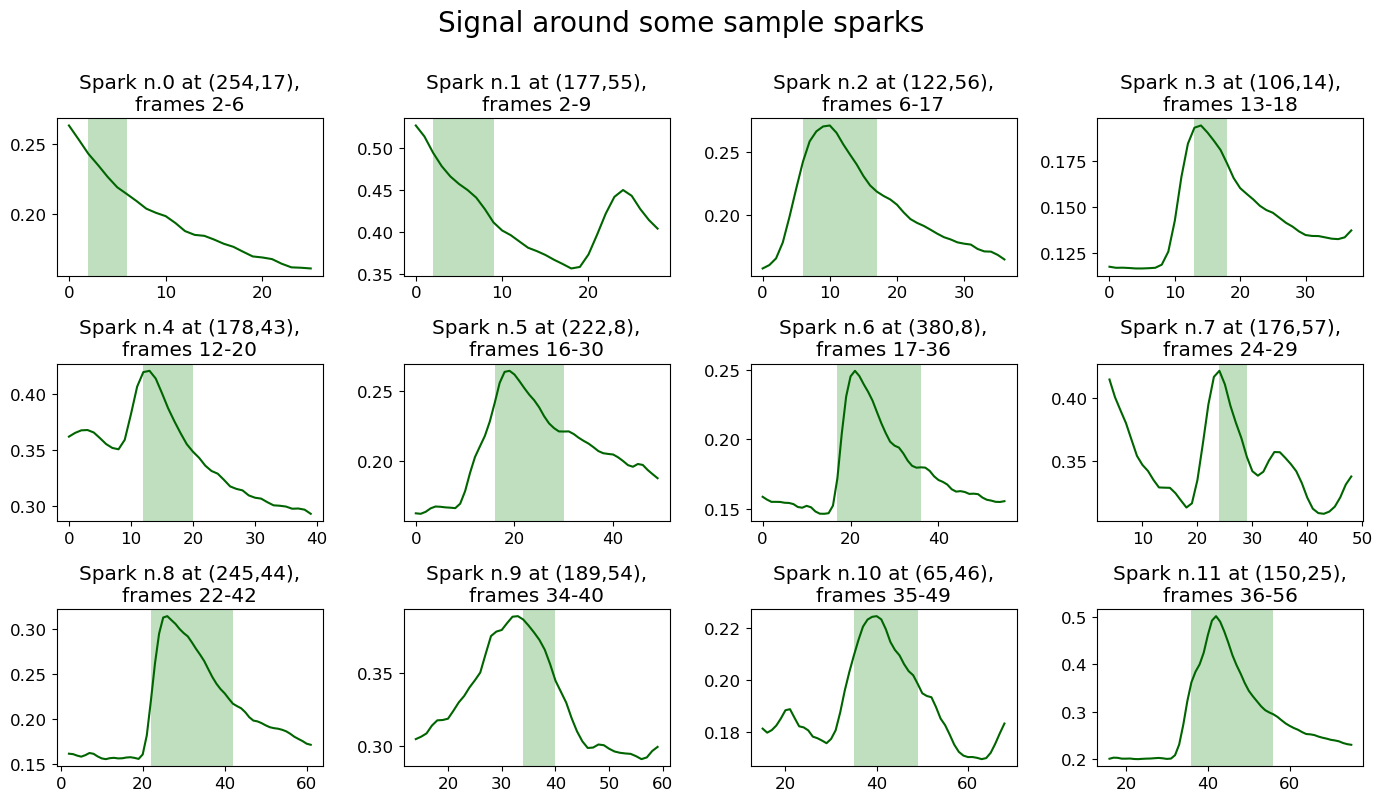

In [12]:
# Plot a few predicted signal samples

# num_samples = len(sparks_pred_loc)
num_samples = 12

plt.rcParams.update({"font.size": 12})

plt.figure(figsize=(2 * (4 + math.ceil(num_samples / 4)), 2 * 4))
plt.suptitle("Signal around some sample sparks", fontsize=20, y=1)

for idx, centre in enumerate(sparks_pred_loc[:num_samples]):
    frames, signal, (y, x), start, stop = get_spark_signal(
        video=smooth_x,
        sparks_labelled=sparks_pred_instances,
        center=centre,
        radius=radius,
        context_duration=context_duration,
        return_info=True,
    )

    # print(idx)
    # print("frames",len(frames))
    # print("signal",len(signal))
    # print("centre",centre)
    # print("start",start,"stop",stop,"diff",stop-start)
    # break
    ax = plt.subplot(math.ceil(num_samples / 4), 4, idx + 1)
    ax.set_title(f"Spark n.{idx} at ({x},{y}),\nframes {start}-{stop}")
    ax.axvspan(start, stop, facecolor="green", alpha=0.25)
    plt.plot(frames, signal, color="darkgreen")

plt.tight_layout()
plt.show()

#### Get 2D signal around center of each spark (for shape analysis)

In [13]:
# assign a slice to each centre
slices_spark_centres = []
for t, y, x in sparks_pred_loc:
    event_nb = sparks_pred_instances[t, y, x]
    event_roi = sparks_pred_instances == event_nb
    event_obj = find_objects(event_roi)[0]
    slices_spark_centres.append(event_obj)

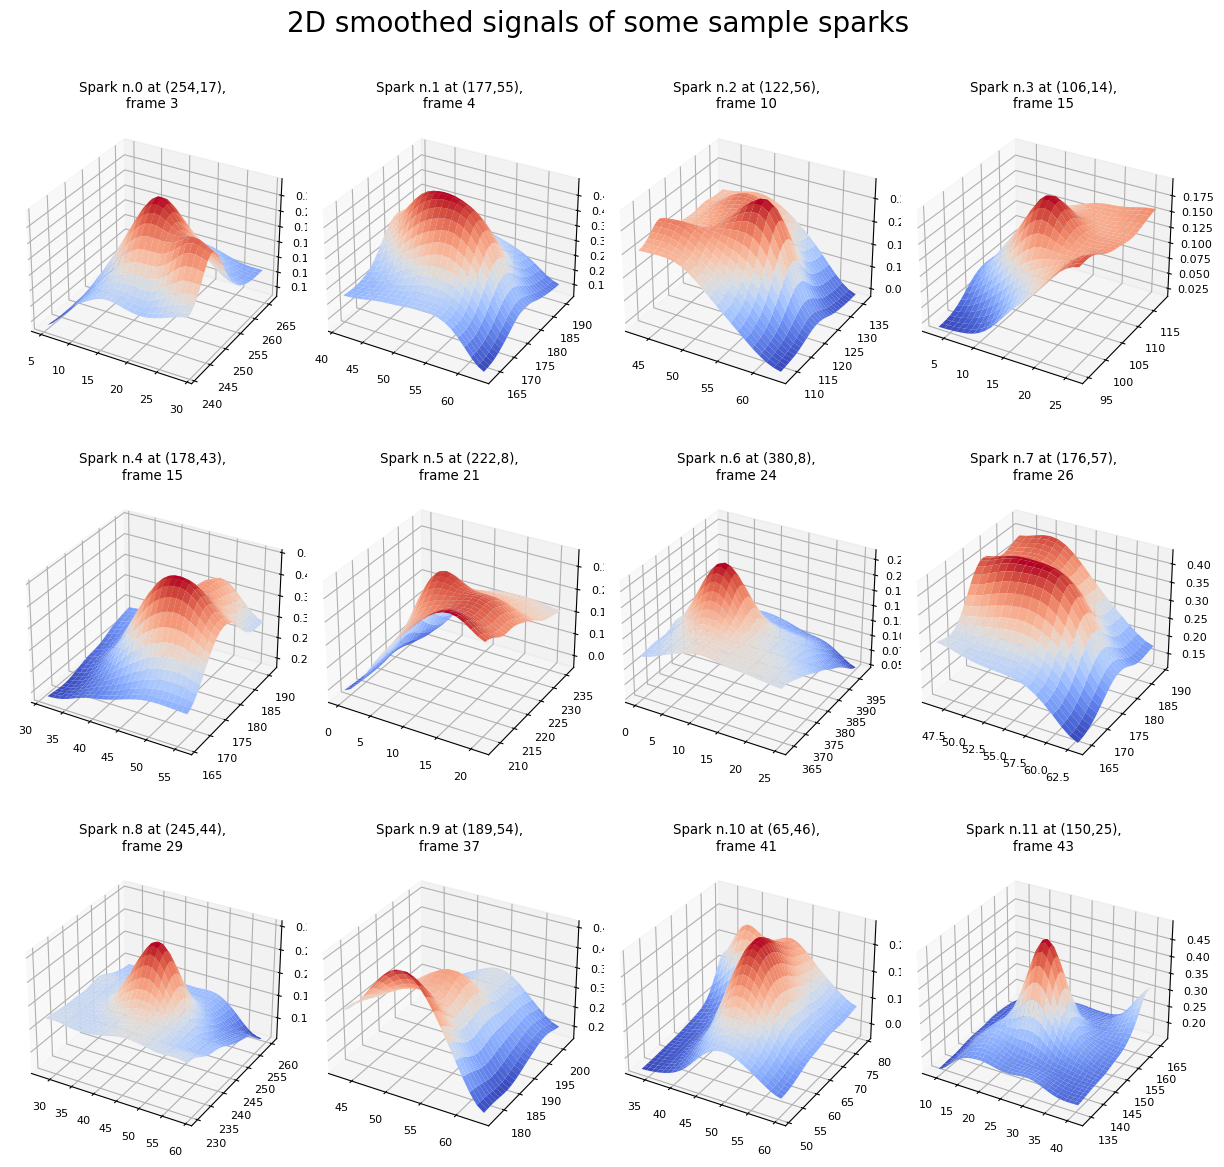

In [14]:
# Plot 2D signal
spatial_context = 10  # consider extended ROI

# n_sparks = len(sparks_pred_loc)
# num_plots = n_sparks
num_plots = 12
plt.figure(figsize=(2 * (3 + math.ceil(num_plots / 4)), 2 * (4 + 2)))

# if n_sparks == 1:
#    plt.suptitle("2D smoothed signal of a sample spark", fontsize=10)
#    idx = 1

#    t,y,x,y_axis,x_axis,signal_2d = get_spark_2d_signal(video_array,
#                                                        slices_spark_centres[idx-1],
#                                                        coords_spark_centres[idx-1],
#                                                        spatial_context,
#                                                        sigma = 2,
#                                                        return_info = True)
#
#    x_axis, y_axis = np.meshgrid(x_axis,y_axis)

#    ax = plt.subplot(1,1,idx, projection='3d')
#    ax.set_title(f"Spark at location ({x},{y}) at frame {t}")
#    ax.plot_surface(y_axis, x_axis, signal_2d, cmap=cm.coolwarm, linewidth=0)#, antialiased=False)
# else:
plt.suptitle("2D smoothed signals of some sample sparks", fontsize=20, y=1)
plt.rcParams.update({"font.size": 8})

for idx in range(num_plots):
    n_rows = num_plots // 4 if num_plots % 4 == 0 else (num_plots // 4) + 1
    t, y, x, y_axis, x_axis, signal_2d = get_spark_2d_signal(
        video=smooth_x,
        slices=slices_spark_centres[idx],
        coords=sparks_pred_loc[idx],
        spatial_context=spatial_context,
        sigma=2,
        return_info=True,
    )

    x_axis, y_axis = np.meshgrid(x_axis, y_axis)

    ax = plt.subplot(n_rows, 4, idx + 1, projection="3d")
    ax.set_title(f"Spark n.{idx} at ({x},{y}),\nframe {t}")
    ax.plot_surface(
        y_axis, x_axis, signal_2d, cmap=cm.coolwarm, linewidth=0
    )  # , antialiased=False)

plt.tight_layout()
plt.show()

### PUFFS (and maybe waves) --> TO DO

In [16]:
puffs_pred_instances = final_instances_dict[movie_id]["puffs"]

puff_ids = np.unique(puffs_pred_instances)
puff_ids = puff_ids[puff_ids != 0]
print("Puff indices:", puff_ids)

Puff indices: [118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159]


In [17]:
def get_puff_signal(
    video, puffs_instances, event_id, context_duration, return_info=False
):
    event_mask = puffs_instances == event_id
    t, h, w = puffs_instances.shape

    loc = find_objects(event_mask)[0]

    # get mask representing puff location (with radius and context)
    start = max(0, loc[0].start - context_duration)
    stop = min(puffs_instances.shape[0], loc[0].stop + context_duration)

    # compute center of mass of the event
    y, x = center_of_mass(np.any(event_mask, axis=0))

    # compute pairwise distances between each pixel and the center of mass
    event_mask_flattened = np.any(event_mask, axis=0)
    distances = euclidean_distances(
        np.array([(y, x)]), np.argwhere(event_mask_flattened)
    )

    # find the maximum distance
    radius = int(np.max(distances))

    signal_mask = create_signal_mask(
        t=t, h=h, w=w, start=start, stop=stop, center=(x, y), radius=radius
    )

    frames = np.arange(start, stop)
    signal = np.average(video[start:stop], axis=(1, 2), weights=signal_mask[start:stop])

    if return_info:
        return frames, signal, (y, x), loc[0].start, loc[0].stop

    return frames, signal

In [18]:
context_duration = 20
puff_id = puff_ids[3]

In [19]:
frames, signal, (y, x), start, stop = get_puff_signal(
    video=smooth_x,
    puffs_instances=puffs_pred_instances,
    event_id=puff_id,
    context_duration=context_duration,
    return_info=True,
)

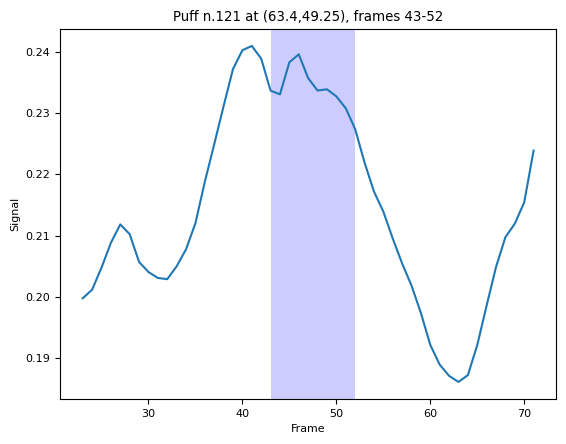

In [20]:
plt.plot(frames, signal)
plt.title(f"Puff n.{puff_id} at ({x},{y}), frames {start}-{stop}")
plt.axvspan(start, stop, facecolor="blue", alpha=0.2)
plt.xlabel("Frame")
plt.ylabel("Signal")
plt.show()

## Visualize removed small events

In [42]:
movie_ids

['05', '10', '15', '20', '25', '32', '34', '40', '45']

In [67]:
sample_id = 8
movie_id = movie_ids[sample_id]

In [68]:
raw_pred = raw_preds[sample_id]  # (4, 500, 64, 512)
sample_movie = xs[sample_id]  # (500, 64, 512)

In [69]:
# Get dict of predicted events
raw_pred_dict = {
    event_type: raw_pred[event_label]
    for event_type, event_label in config.classes_dict.items()
    if event_type != "ignore"
}

In [70]:
# Get argmax segmentation using Otsu threshold on summed predictions
pred_segmentation_dict, _ = get_otsu_argmax_segmentation(
    preds=raw_pred_dict, return_classes=True, debug=False
)

In [71]:
# Separate events in predictions
pred_instances_dict, coords_events = get_separated_events(
    argmax_preds=pred_segmentation_dict,
    movie=sample_movie,
    debug=False,
    training_mode=False,
)

In [72]:
# Remove small events and merge events that belong together
# Labelling removed events with a new id (9999)
new_id = 9999
clean_pred_instances_dict = remove_small_events(
    instances_dict=pred_instances_dict, new_id=new_id
)

In [73]:
removed_instances_dict = {}
for event_type in pred_instances_dict.keys():
    original_instances = pred_instances_dict[event_type]
    clean_instances = clean_pred_instances_dict[event_type]

    mask = np.where(clean_instances == new_id, original_instances, 0)
    removed_instances_dict[event_type] = mask

In [74]:
viewer = napari.Viewer()

viewer.add_image(sample_movie, name="movie", colormap=("colors", cmap), opacity=0.5)

# Visualize predicted events' segmentation
pred_segmentation = preds_dict_to_mask(preds_dict=pred_segmentation_dict)
viewer.add_labels(
    pred_segmentation,
    name="segmented predictions",
    opacity=0.25,
    color=labels_cmap,
    blending="additive",
)

# Visualize annotated events' contours
y_contours = get_annotations_contour(annotations=ys[sample_id], contour_val=2)
viewer.add_labels(
    y_contours,
    name="annotated segmentation",
    opacity=0.25,
    color=labels_cmap,
    blending="additive",
)
# Visualize removed event's in a different color
custom_cmap = {
    0: (0, 0, 0, 0),  # no color
    1: (0, 0, 1, 1),  # blue
    2: (0, 0, 1, 1),  # blue
    3: (0, 0, 1, 1),  # blue
}
removed_instances_mask = preds_dict_to_mask(preds_dict=removed_instances_dict)
viewer.add_labels(
    removed_instances_mask,
    name="removed instances",
    opacity=1.0,
    color=custom_cmap,
    blending="additive",
)

# # Visualize removed instances
# for event_type, event_instances in removed_instances_dict.items():
#     if event_instances.max() > 0:
#         viewer.add_labels(event_instances, name=event_type, blending="additive")

<Labels layer 'removed instances' at 0x21234e7d480>

**Minimal Dimensions to Remove Small Events in U-Net Detections**

The following parameters control the minimal dimensions to remove small events in UNet detections:

| Event Type | Duration | Height | Width |
|------------|----------|--------|-------|
| Sparks     | 2 frames | 3 pixels | 3 pixels |
| Waves      | No minimum | No minimum | 15 pixels |
| Puffs      | 5 frames | No minimum | No minimum |

**Maximal Gap Between Two Predicted Puffs or Waves That Belong Together**

The following parameters determine the maximal gap between two predicted puffs or waves that belong together (measured in frames):

| Event Type | Max Gap (in frames) |
|------------|----------------------|
| Sparks     | No maximum           |
| Waves      | Up to 2 frames       |
| Puffs      | Up to 2 frames       |

**Comments about removed events**

| Movie ID | Comments |
|------------|----------------------|
| *05*     | Some events are removed but they are very small, removed events mostly make sense |
| *10*     | Same as 05 |
| *15*     | Same as 05 |
| *20*     | Same as 05 |
| *25*     | Ok |
| *32*     | Same as 05 |
| *34*     | Some waves on the right border of cell are removed! Maybe the params for removing waves should be more restrictive |
| *40*     | Same as 05 |
| *45*     | Ok |


**General remarks** (for future model improvement):
- I should annotated as "ignore" all events that overlap with the first and last ~6 frames of the movies
- Movie 05 should be split where there is a jump in the recording
- Movie 45 does not contain annotations for sparks and puffs, maybe I should remove detected sparks and puffs from it (they count as false positive)
